In [1]:
from caits.loading import csv_loader
import numpy as np
import pandas as pd

In [3]:
loaded_data = csv_loader("data/GestureSet_small")
loaded_data

Loading CSV files: 100%|██████████| 924/924 [00:00<00:00, 2069.50it/s]


{'X': [     acc_x_axis_g  acc_y_axis_g  acc_z_axis_g  gyr_x_axis_deg/s  \
  0           1.332         0.356         0.156           -74.207   
  1           1.751         0.146         0.178           -29.695   
  2           1.450        -0.049         0.252            -2.805   
  3           0.688         0.136         0.447            -3.902   
  4           0.182         0.533         0.552           -10.000   
  ..            ...           ...           ...               ...   
  123         0.259         0.614         0.423            22.378   
  124         0.259         0.614         0.459            13.293   
  125         0.383         0.635         0.447             0.793   
  126         0.397         0.636         0.445            -5.854   
  127         0.361         0.632         0.437            -3.232   
  
       gyr_y_axis_deg/s  gyr_z_axis_deg/s  
  0             -43.476          -101.098  
  1             -16.098           -61.524  
  2               3.110         

In [3]:
from caits.dataset import CoreArray, DatasetList

data = DatasetList(
    [CoreArray(x.values, axis_names={"axis_1": x.columns}) for x in loaded_data["X"]],
    loaded_data["y"],
    loaded_data["id"]
)

data

DatasetList object with 924 instances.

In [4]:
from caits.transformers import (
    SlidingWindow,
    FunctionTransformer,
)
from caits.filtering import filter_butterworth
from sklearn.pipeline import Pipeline

In [5]:
WINDOW_SIZE = 28
OVERLAP = int(0.9 * WINDOW_SIZE)


pipe1 = Pipeline(
    [
        ("window", SlidingWindow(window_size=WINDOW_SIZE, overlap=OVERLAP)),
        ('filter', FunctionTransformer(
            func=filter_butterworth,
            fs=100,
            cutoff_freq=20,
            method="sosfiltfilt"
        )),
    ]
)

transformed_data = pipe1.fit_transform(data)
transformed_data

DatasetList object with 36184 instances.

In [6]:
train, test = transformed_data.train_test_split(test_size=0.2, random_state=42, stratified=True)
train

DatasetList object with 28949 instances.

In [7]:
test

DatasetList object with 7235 instances.

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from caits.transformers import (
    DatasetToArray,
    SklearnWrapper,
    ArrayToDataset,
)

pipe2 = Pipeline(
    [
        ('flatten', DatasetToArray(flatten=True)),
        ('scaler', SklearnWrapper(MinMaxScaler)),
        ('pca', SklearnWrapper(PCA, {"n_components": 0.75})),
    ]
)

train_transformed = pipe2.fit_transform(train)
test_transformed = pipe2.transform(test)
train_transformed


DatasetArray object with 28949 instances.

In [9]:
train_transformed.X.shape

(28949, 8)

In [10]:
test_transformed.X.shape

(7235, 8)

In [11]:
pipe2.steps[2][1].fitted_transformer_.explained_variance_ratio_

array([0.2597882 , 0.11995173, 0.10647424, 0.091819  , 0.06646103,
       0.03935783, 0.03744824, 0.03437754])

In [12]:
labels_to_keep = list(set(train_transformed.y).union(set(test_transformed.y)))
N = len(labels_to_keep)
labels_to_keep, N

(['01e', '01d', '02a', '03a'], 4)

In [13]:
from sklearn.preprocessing import LabelEncoder

X_train = train_transformed.X.values
X_test = test_transformed.X.values

y_encoder = LabelEncoder()
y_train = y_encoder.fit_transform(train_transformed.y)
y_test = y_encoder.transform(test_transformed.y)


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28949, 8), (7235, 8), (28949,), (7235,))

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [16]:
SVC_C = 1
SVC_kernel = "rbf"
SVC_gamma = 0.005

clf = SVC(C=SVC_C, kernel=SVC_kernel, gamma=SVC_gamma)
clf.fit(X_train, y_train)


SVC(C=1, gamma=0.005)

In [17]:
predictions = clf.predict(X_test)
predictions

array([3, 3, 3, ..., 0, 0, 0])

In [18]:
clf.classes_

array([0, 1, 2, 3])

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, predictions)

array([[1902,   18,    0,   74],
       [1025,  189,    6,  366],
       [ 313,   23,    2, 1045],
       [ 296,    9,    7, 1960]])

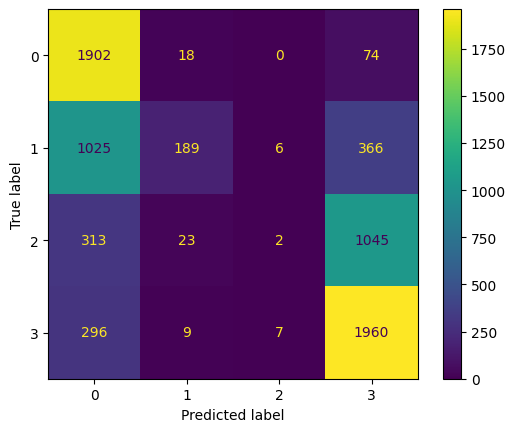

In [20]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.54      0.95      0.69      1994
           1       0.79      0.12      0.21      1586
           2       0.13      0.00      0.00      1383
           3       0.57      0.86      0.69      2272

    accuracy                           0.56      7235
   macro avg       0.51      0.48      0.40      7235
weighted avg       0.53      0.56      0.45      7235



In [22]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [30]:
pipe3 = Pipeline(
    [
        ('flatten', DatasetToArray(flatten=True)),
        ('scaler', SklearnWrapper(MinMaxScaler)),
        ('unflatten', ArrayToDataset(shape=(28, 6)))
    ]
)

train_2D = pipe3.fit_transform(train)
test_2D = pipe3.transform(test)

In [31]:
input_data_shape = train_2D.X[0].shape
input_data_shape

(28, 6)

In [58]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=input_data_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation="relu"))
model.add(Dense(N, activation="softmax"))

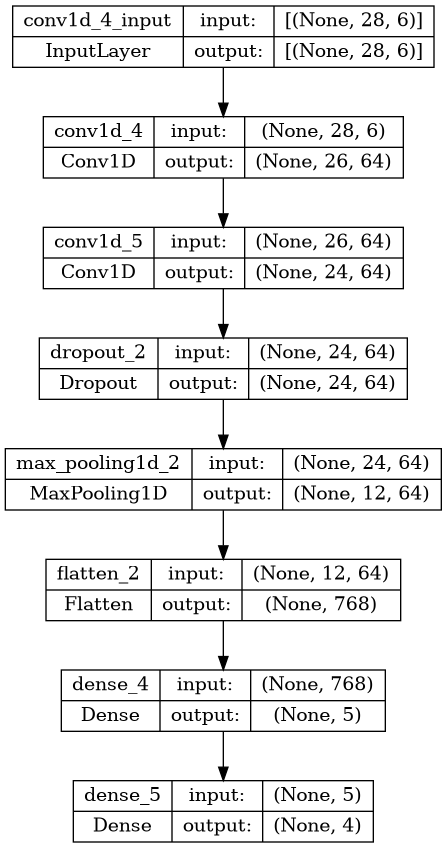

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 26, 64)            1216      
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 64)            12352     
                                                                 
 dropout_2 (Dropout)         (None, 24, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 3845      
                                                      

In [61]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [62]:
train, val = train_2D.train_test_split(test_size=0.15, random_state=42, stratified=True)
train_X, train_y, _ = train.to_numpy()
val_X, val_y, _ = val.to_numpy()
test_X, test_y, _ = test_2D.to_numpy()

train_y = y_encoder.transform(train_y)
val_y = y_encoder.transform(val_y)
test_y = y_encoder.transform(test_y)


In [63]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)


(24609, 28, 6)
(24609,)
(4340, 28, 6)
(4340,)
(7235, 28, 6)
(7235,)


In [64]:
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(val_X, val_y), verbose=2)

Epoch 1/100
770/770 - 2s - loss: 1.1493 - accuracy: 0.4718 - val_loss: 1.2524 - val_accuracy: 0.3751 - 2s/epoch - 3ms/step
Epoch 2/100
770/770 - 2s - loss: 0.9276 - accuracy: 0.5784 - val_loss: 0.8776 - val_accuracy: 0.6090 - 2s/epoch - 2ms/step
Epoch 3/100
770/770 - 2s - loss: 0.8198 - accuracy: 0.6292 - val_loss: 0.8688 - val_accuracy: 0.6078 - 2s/epoch - 2ms/step
Epoch 4/100
770/770 - 2s - loss: 0.7794 - accuracy: 0.6461 - val_loss: 0.7814 - val_accuracy: 0.6523 - 2s/epoch - 2ms/step
Epoch 5/100
770/770 - 2s - loss: 0.7268 - accuracy: 0.6739 - val_loss: 0.7077 - val_accuracy: 0.7108 - 2s/epoch - 2ms/step
Epoch 6/100
770/770 - 2s - loss: 0.6885 - accuracy: 0.6927 - val_loss: 0.6801 - val_accuracy: 0.7290 - 2s/epoch - 2ms/step
Epoch 7/100
770/770 - 2s - loss: 0.6570 - accuracy: 0.7185 - val_loss: 0.7233 - val_accuracy: 0.6818 - 2s/epoch - 2ms/step
Epoch 8/100
770/770 - 2s - loss: 0.6172 - accuracy: 0.7457 - val_loss: 0.6362 - val_accuracy: 0.7412 - 2s/epoch - 2ms/step
Epoch 9/100
770/

In [65]:
loss, accuracy = model.evaluate(test_X, test_y, batch_size=32, verbose=2)


227/227 - 0s - loss: 0.1868 - accuracy: 0.9314 - 183ms/epoch - 806us/step


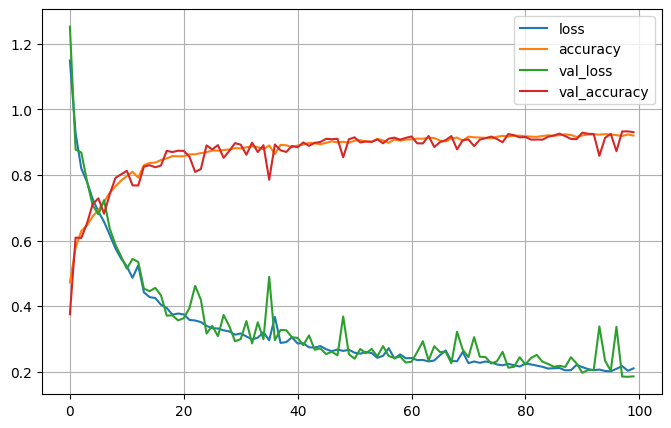

In [66]:
import matplotlib.pyplot as plt

learning_curves = pd.DataFrame(history.history)
learning_curves.plot(figsize=(8, 5))
plt.grid(True)
plt.show()